In [1]:
import gym
gym.logger.set_level(40)

import random
import numpy as np
from collections import deque

import torch

from IPython import display
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from ddpg import DDPGAgent
from model import Actor, Critic

In [5]:
#https://github.com/AminHP/gym-anytrading
import gym
import gym_anytrading

env = gym.make('forex-v0')

In [6]:
env.observation_space

Box(24, 2)

In [8]:
env.action_space

Discrete(2)

In [3]:


o_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
print('State shape: ', o_dim)
print('Action shape: ', a_dim)

# each action dim value ranges from -1 to 1, so add tanh as to the actor network
print(env.action_space.high,env.action_space.low)
# action scale and state scale are different, so apply a separate layer before concat
print(env.observation_space.high,env.observation_space.low)


You appear to be missing MuJoCo.  We expected to find the file here: /Users/yierwan/.mujoco/mujoco200

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html



Exception: 
You appear to be missing MuJoCo.  We expected to find the file here: /Users/yierwan/.mujoco/mujoco200

This package only provides python bindings, the library must be installed separately.

Please follow the instructions on the README to install MuJoCo

    https://github.com/openai/mujoco-py#install-mujoco

Which can be downloaded from the website

    https://www.roboti.us/index.html


In [3]:
# agent parameters
LR_ACTOR = 1e-4         # actor learning rate
LR_CRITIC = 1e-3        # critic learning rate
WEIGHT_DECAY = 1e-2     # critic weight decay (L2 regularization)
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
BUFFER_SIZE = int(1e6)  # replay buffer size
UPDATE_EVERY = 1        
SEED = 1234

agent = DDPGAgent(Actor, Critic, o_dim, a_dim, initialize_weights = True,
                  lr_actor = LR_ACTOR, lr_critic = LR_CRITIC, weight_decay = WEIGHT_DECAY,
                  batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, buffer_size = BUFFER_SIZE,
                  update_every = UPDATE_EVERY, seed = SEED)

print(agent.actor)
print(agent.critic)
print(agent.loss_fn)
print(agent.initialize_weights)

Actor(
  (main): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
    (3): Tanh()
  )
)
Critic(
  (obs_fc): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (main): Sequential(
    (0): Linear(in_features=260, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SmoothL1Loss()
True


In [4]:
# parameters for training
NUM_EPISODES = 200
PRINT_EVERY = 50
TMAX = 500

eps_start = 1.0
eps_end = 0.1
eps_decay = 0.95

In [5]:
score_list = []
score_window = deque(maxlen = PRINT_EVERY)  
best_score = 0.0

eps = eps_start
for e in range(1, NUM_EPISODES+1):
    
    state = env.reset() # reset environment
    agent.reset() # reset noise process
    score = 0
    for t in range(TMAX):
        action = agent.get_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        
        if mean_score >= best_score:
            print('\nmodel saved!')
            torch.save(agent.online_net.state_dict(), 'checkpoint.pth')
            best_score = mean_score



Episode 50	sum of rewards   -99.47
Episode 100	sum of rewards  -101.18
Episode 150	sum of rewards  -101.17
Episode 200	sum of rewards  -101.17


In [6]:
# load checkpoint
#agent.online_net.load_state_dict(torch.load('checkpoint.pth'))
# load to cpu and save the best weights
torch.save(agent.actor.cpu().state_dict(), "ddpg_BipedalWalker.pth")

score1 = np.asarray(score_list).T

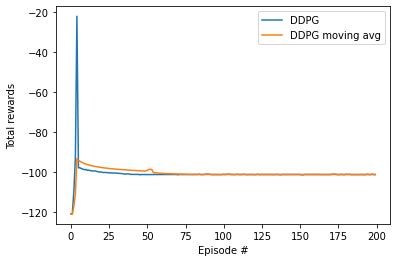

In [7]:
fig = plt.figure()
plt.plot(np.arange(score1.shape[1]), score1[0], label = "DDPG")
plt.plot(np.arange(score1.shape[1]), score1[1], label = "DDPG moving avg")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [8]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

env = wrap_env( gym.make('BipedalWalker-v3'))

state = env.reset()
while True:
    action = agent.get_action(state, False)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break


env.close()

## initialize weights

In [19]:
actor = Actor(o_dim, a_dim, True)
#actor = Actor(o_dim, a_dim, False)
list(actor.main.parameters())

[Parameter containing:
 tensor([[ 0.0691,  0.1220,  0.1721,  ..., -0.1993,  0.1692, -0.0397],
         [-0.0687, -0.0046, -0.1212,  ..., -0.1275, -0.0436, -0.0287],
         [-0.1893, -0.1883,  0.1834,  ...,  0.0366, -0.0533,  0.0737],
         ...,
         [-0.1420, -0.0039,  0.0071,  ...,  0.0761,  0.1402,  0.1757],
         [ 0.1563, -0.1403,  0.0060,  ..., -0.1436,  0.1064,  0.0408],
         [-0.1372,  0.1024,  0.1175,  ..., -0.0079,  0.0717, -0.0367]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [17]:
critic = Critic(o_dim, a_dim, True)
#critic = Critic(o_dim, a_dim, False)
#list(critic.obs_fc.parameters())
list(critic.main.parameters())

[Parameter containing:
 tensor([[-0.0299,  0.0578,  0.0418,  ...,  0.0140, -0.0559,  0.0068],
         [ 0.0469, -0.0055, -0.0122,  ...,  0.0425,  0.0206, -0.0418],
         [ 0.0124, -0.0605, -0.0483,  ...,  0.0008, -0.0436,  0.0006],
         ...,
         [-0.0438,  0.0277, -0.0285,  ...,  0.0133, -0.0296, -0.0299],
         [ 0.0095,  0.0494,  0.0073,  ..., -0.0423,  0.0490,  0.0083],
         [-0.0102,  0.0479, -0.0037,  ...,  0.0182, -0.0420,  0.0228]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,